# Calculate the pressure variables from SUNTANS output

$$
p_B = \rho_0 g \left[ (\eta + H) +  \eta_s - \eta_A\right]
$$
where
$$
\eta_s = \int_{-H}^{\eta} \frac{\rho'}{\rho_0}dz
$$
is the steric height, and 
$$
\eta_A = \frac{p_A}{\rho_0 g}
$$
is the inverse barometer sea level.

# Dask worker setup instructions

https://github.com/mrayson/pawsey-containers/tree/master/hpc-python/jupyter-sfoda

 - `ssh localhost "cd /software/projects/pawsey0106/mrayson/projects && sbatch --ntasks=8 -c 8 start_worker.slm scheduler-$HOSTNAME.json ./"`

In [1]:
!echo $(hostname)

nid001315


In [2]:
import os
from distributed import Client
client=Client(scheduler_file='../../scheduler-' + 'nid001315' + '.json')
client

<Client: 'tcp://10.253.2.160:8786' processes=8 threads=32, memory=53.74 GiB>

In [2]:
# from dask.distributed import Client
# from dask.distributed import LocalCluster
# # cluster=LocalCluster(n_workers=32,
# #         threads_per_worker=4)
# cluster=LocalCluster()
# client = Client(cluster)
# cluster

In [3]:
import glob
import xarray as xr
import numpy as np
import dask.array as da

from sfoda.suntans import sunxarray as sxr

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-wkuw5hz3 because the default path (/home/mrayson/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
runnum = 1
basedir =  '/scratch/pawsey0106/mrayson//SUNTANS_NWS_2km/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data{}/'.format(runnum)
ncfiles = '{}/*.nc.*'.format(basedir)
filenames = sorted(glob.glob(ncfiles))
filenames[0], filenames[-1]

('/scratch/pawsey0106/mrayson//SUNTANS_NWS_2km/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data1/NWS_2km_GLORYS_hex_20130701.nc.0',
 '/scratch/pawsey0106/mrayson//SUNTANS_NWS_2km/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data1/NWS_2km_GLORYS_hex_20130701.nc.99')

In [5]:
%%time
ds = sxr.open_parallel(filenames)
ds

/opt/conda/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


CPU times: user 13.8 s, sys: 3.22 s, total: 17.1 s
Wall time: 47.3 s


<xarray.Dataset>
Dimensions:       (Nc: 225368, numsides: 8, Np: 454016, Nk: 80, Nkw: 81,
                   time: 745)
Coordinates:
    Nk            (Nc) int32 dask.array<chunksize=(973,), meta=np.ndarray>
    xv            (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    yv            (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    z_r           (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    z_w           (Nkw) float64 dask.array<chunksize=(81,), meta=np.ndarray>
  * time          (time) datetime64[ns] 2013-07-01T00:01:00 ... 2013-08-01
Dimensions without coordinates: Nc, numsides, Np, Nkw
Data variables: (12/36)
    suntans_mesh  int32 -2147483647
    cells         (Nc, numsides) int32 dask.array<chunksize=(973, 8), meta=np.ndarray>
    face          (Nc, numsides) int32 dask.array<chunksize=(973, 8), meta=np.ndarray>
    nfaces        (Nc) int32 dask.array<chunksize=(973,), meta=np.ndarray>
    neigh         (Nc, numsides) int32 dask.array<chunksize=(973, 8), meta=np.ndarray>
    mnptr         (Nc) int32 dask.array<chunksize=(973,), meta=np.ndarray>
    ...            ...
    Hl            (time, Nc) float64 dask.array<chunksize=(745, 973), meta=np.ndarray>
    Hlw           (time, Nc) float64 dask.array<chunksize=(745, 973), meta=np.ndarray>
    Hsw           (time, Nc) float64 dask.array<chunksize=(745, 973), meta=np.ndarray>
    tau_x         (time, Nc) float64 dask.array<chunksize=(745, 973), meta=np.ndarray>
    tau_y         (time, Nc) float64 dask.array<chunksize=(745, 973), meta=np.ndarray>
    EP            (time, Nc) float64 dask.array<chunksize=(745, 973), meta=np.ndarray>
Attributes:
    title:    SUNTANS NetCDF output file

In [8]:
# Load the initial density
#@rho0 = ds['rho'].isel(time=0)*1000+1000
#rho0 = rho0.persist()

rho0 = (ds['rho']*1000+1000).isel(time=0)
rho0 = rho0.persist()

In [9]:
rho0

<xarray.DataArray 'rho' (Nk: 80, Nc: 225368)>
dask.array<getitem, shape=(80, 225368), dtype=float64, chunksize=(80, 8466), chunktype=numpy.ndarray>
Coordinates:
    Nk       (Nc) int32 dask.array<chunksize=(973,), meta=np.ndarray>
    xv       (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    yv       (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    z_r      (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    time     datetime64[ns] 2013-07-01T00:01:00
Dimensions without coordinates: Nc

In [10]:
# Calculate dzz0 - initial vertical spacing
dz = ds['dz'].values
Nc = ds['Nc'].values
Nk = ds['Nk'].values
H = ds['dv'].values

KeyboardInterrupt: 

In [11]:
# Calculate dz of the near-bed layer thickness and zero layers below that
N = ds.dims['ssh Nc']
K = ds.dims['Nk']
dzz = dz[:,None] * np.ones((1,N))

z = np.cumsum(dzz,axis=0)
dzbed = np.zeros((N,))
for ii in range(N):
    k = Nk[ii]-1
    dzbed[ii] = -H[ii]+z[k,ii]
    dzz[k,ii] = dzbed[ii]
    dzz[k+1:,ii] = 0.
    
dzz_da = da.from_array(dzz, chunks=rho0.chunks)

In [12]:
rho = ds['rho'].isel(time=[500,501])*1000+1000
rhopr = rho-rho0
eta_s = (rhopr*dzz).sum(axis=1)
eta_s

<xarray.DataArray 'rho' (time: 2, Nc: 225368)>
dask.array<sum-aggregate, shape=(2, 225368), dtype=float64, chunksize=(2, 8466), chunktype=numpy.ndarray>
Coordinates:
    Nk       (Nc) int32 dask.array<chunksize=(973,), meta=np.ndarray>
    xv       (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    yv       (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2013-07-21T20:00:00 2013-07-21T21:00:00
Dimensions without coordinates: Nc

Changing the _FillValue from -999999 to 999999


2022-08-05 15:22:34,604 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.47 GiB -- Worker memory limit: 14.38 GiB
2022-08-05 15:22:34,610 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.47 GiB -- Worker memory limit: 14.38 GiB
2022-08-05 15:22:34,690 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2022-08-05 15:22:37,925 - distributed.worker_memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 11.54 GiB -- Worker memory limit: 14.38 GiB
2022-08-05 15:22:37,925 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.54 GiB -- Worker memory limit: 14.38 GiB
2022-08-05 15:22:37,970 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.98 GiB -- Worker memory limit: 14.38 GiB
2022-08-05 15:22:37,991 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memo

2022-08-05 15:22:40,090 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.06 GiB -- Worker memory limit: 14.38 GiB
2022-08-05 15:22:40,192 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.11 GiB -- Worker memory limit: 14.38 GiB
2022-08-05 15:22:40,290 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2022-08-05 15:22:54,018 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.45 GiB -- Worker memory limit: 14.38 GiB
2022-08-05 15:22:54,116 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.50 GiB -- Worker memory limit: 14.38 GiB
2022-08-05 15:22:54,935 - distributed.worker_memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 11.58 GiB -- Worker memory limit: 14.38 GiB
2022-08-05 15:22:54,935 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memo

2022-08-05 15:23:00,617 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.64 GiB -- Worker memory limit: 14.38 GiB
2022-08-05 15:23:00,714 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.70 GiB -- Worker memory limit: 14.38 GiB
2022-08-05 15:23:00,818 - distributed.worker_memory - WARNING - Worker is at 28% memory usage. Resuming worker. Process memory: 4.03 GiB -- Worker memory limit: 14.38 GiB


KeyboardInterrupt: 

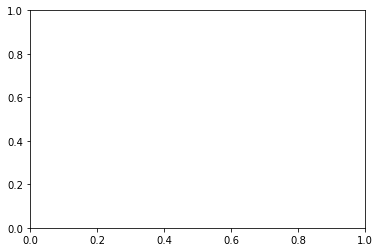

In [13]:
ds.suntans.plotcelldata(eta_s[0,...])